In [1]:
from src.model import VAE
from src.trainer import CDVAETrainer
from src.model import interpolate_latent
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

%load_ext autoreload
%autoreload 2

In [2]:
from corruption_utils import corruptions

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
%%capture
mnist = torchvision.datasets.MNIST("../data", train=True, download=True)

In [5]:
from src.utils import CMNISTGenerator, CMNIST

In [6]:
def display_util(idx1, idx2, z: torch.Tensor, model: VAE, z_dim):
    with torch.no_grad():
        z1, z2 = z[idx1], z[idx2]
        display(transforms.ToPILImage()(model.decode(z1.view(1, -1))[0]))
        display(transforms.ToPILImage()(model.decode(z2.view(1, -1))[0]))
        z_inter = interpolate_latent(latent1=z1[z_dim:], latent2=z2[z_dim:], num_steps=11, device=device)
        z_combined = torch.cat([z1[:z_dim][None, :].repeat(11, 1), z_inter], dim=1)
        x_inter = model.decode(z_combined)
        print("interpolate style:")
        plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
        plt.axis('off')
        plt.show()

        z_inter = interpolate_latent(latent1=z1[:z_dim], latent2=z2[:z_dim], num_steps=11, device=device)
        z_combined = torch.cat([z_inter, z1[z_dim:][None, :].repeat(11, 1)], dim=1)
        x_inter = model.decode(z_combined)
        print("interpolate content:")
        plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
        plt.axis('off')
        plt.show()


In [7]:
generator = CMNISTGenerator(
    mnist,
    {
        corruptions.identity: 0.2,
        corruptions.stripe: 0.2,
        corruptions.zigzag: 0.3,
        corruptions.canny_edges: 0.1,
        corruptions.brightness: 0.2
    },
)


In [8]:
dataset = CMNIST(
    generator, transforms.Compose([transforms.ToTensor(), lambda img: img / 255.0])
)

test, train = random_split(dataset, [32, len(dataset) - 32])
valid, train = random_split(train, [10000, len(train) - 10000])


Generating dataset: 100%|██████████| 60000/60000 [00:15<00:00, 3986.32item/s]


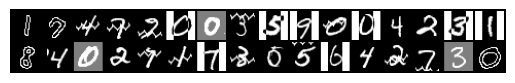

In [72]:
test_loader = DataLoader(test, batch_size=32, shuffle=False)


X, label, _ = next(iter(test_loader))
X = X.to(device)
label = label.to(device)

plt.imshow(
    make_grid(X.cpu(), nrow=16).permute(1, 2, 0)
)
plt.axis('off')
plt.show()


### cosine sim + label-flipping

In [22]:
Z_DIM = 32
TEMP = 0.1
ALPHA = [1e2, 1e2]
LABEL_FLIPPING = True

In [23]:
vae = VAE(total_z_dim=Z_DIM).to(device)
dataloader = DataLoader(train, batch_size=128, shuffle=True)
val_dataloader = DataLoader(valid, batch_size=128, shuffle=False)
optimizer = torch.optim.Adam(vae.parameters(), lr=5e-4)
trainer = CDVAETrainer(
    vae,
    optimizer,
    sim_fn="cosine",
    hyperparameter={"temperature": TEMP, "beta": 1, "loc": 0, "scale": 1,
                    "alpha": ALPHA, "label_flipping": LABEL_FLIPPING},
    verbose_period=5,
    device=device,
)

In [ ]:
trainer.fit(16, dataloader, val_dataloader)

In [14]:
X, label, _ = next(iter(test_loader))
X = X.to(device)
label = label.to(device)


In [15]:
vae.eval()
X_hat, latent_params, z = vae(X.clone(), explicit=True)

interpolate style:


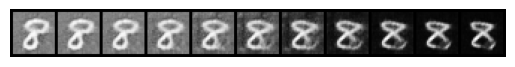

interpolate content:


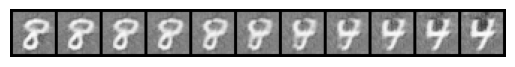

In [16]:
display_util(9, 26, z, vae, int(Z_DIM / 2))

interpolate style:


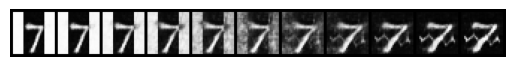

interpolate content:


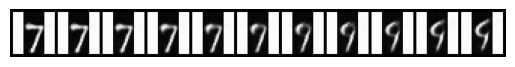

In [17]:
display_util(1, 3, z, vae, int(Z_DIM / 2))

interpolate style:


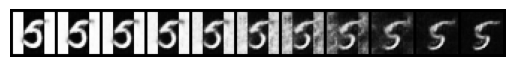

interpolate content:


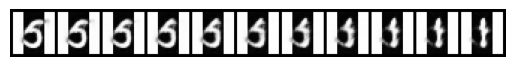

In [18]:
display_util(17, 30, z, vae, int(Z_DIM / 2))

interpolate style:


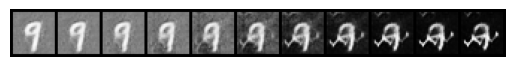

interpolate content:


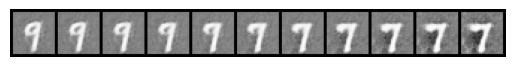

In [19]:
display_util(14, 6, z, vae, int(Z_DIM / 2))

interpolate style:


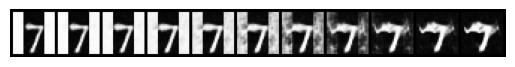

interpolate content:


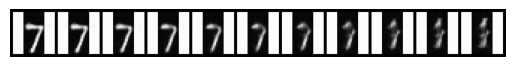

In [20]:
display_util(1, 31, z, vae, int(Z_DIM / 2))

In [21]:
from tqdm import tqdm

mu_cs = []
mu_ss = []
labels = []
styles = []
with torch.no_grad():
    for X, label, style in tqdm(val_dataloader):
        X = X.to(device)
        label = label.to(device)

        _, latent_params = vae(X)
        mu_cs.append(latent_params['mu_c'])
        mu_ss.append(latent_params['mu_s'])
        labels.append(label)
        styles.append(style)

mu_cs = torch.cat(mu_cs, dim=0)
mu_ss = torch.cat(mu_ss, dim=0)
labels = torch.cat(labels, dim=0)
styles = torch.cat(styles, dim=0)


100%|██████████| 79/79 [00:00<00:00, 269.55it/s]


In [22]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_cs_tsne = tsne.fit_transform(mu_cs.cpu().numpy())

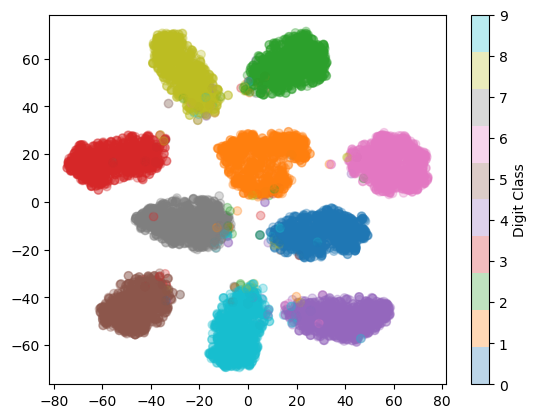

In [23]:
import matplotlib.pyplot as plt

plt.scatter(mu_cs_tsne[:, 0], mu_cs_tsne[:, 1], alpha=0.3, 
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

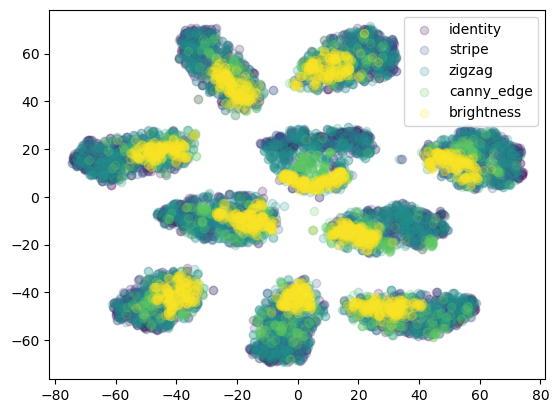

In [24]:
style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', 'brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]

fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_cs_tsne[i,0], mu_cs_tsne[i,1], alpha=0.2, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

In [25]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_ss_tsne = tsne.fit_transform(mu_ss.cpu().numpy())

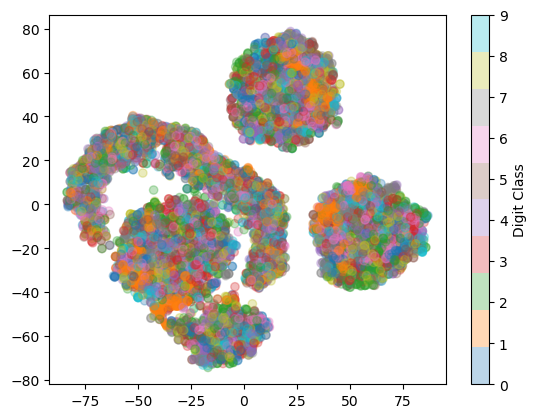

In [26]:
plt.scatter(mu_ss_tsne[:,0], mu_ss_tsne[:,1], alpha=0.3,
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

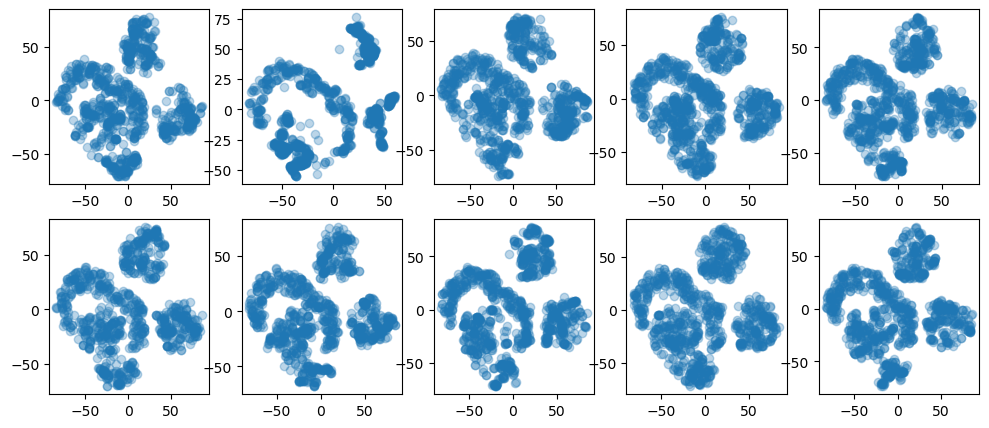

In [27]:
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axs.flat):
    cond = torch.where(labels == i)[0].cpu().numpy()
    ax.scatter(mu_ss_tsne[cond,0], mu_ss_tsne[cond,1], alpha=0.3)

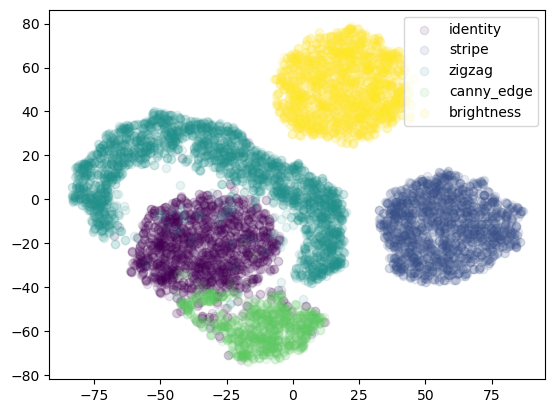

In [32]:
style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', 'brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]
fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_ss_tsne[i,0], mu_ss_tsne[i,1], alpha=0.1, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

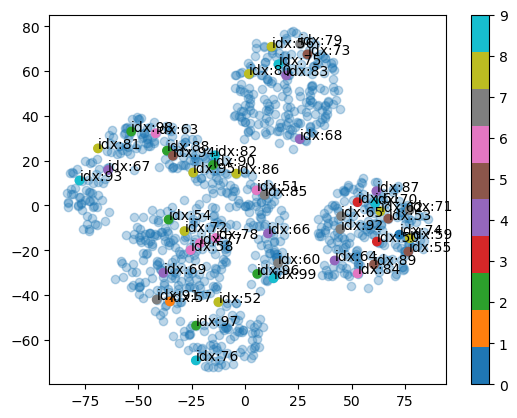

In [29]:
idxs = list(range(50, 100))

plt.scatter(mu_ss_tsne[:1000, 0], mu_ss_tsne[:1000, 1], alpha=0.3)
plt.scatter(mu_ss_tsne[idxs, 0], mu_ss_tsne[idxs, 1], c=labels[idxs].cpu().numpy(), cmap="tab10")
for i in idxs:
    plt.text(mu_ss_tsne[i, 0], mu_ss_tsne[i, 1], f"idx:{i}", fontsize=10)
plt.colorbar()

In [30]:
idx = 99
display(transforms.ToPILImage()(vae.decode(
    torch.cat([mu_cs[idx], mu_ss[idx]]).view(1, -1)
)[0]))

In [31]:
for i in [53, 88, 62, 67, 73, 85, 71, 79, 98, 68]:
    display(transforms.ToPILImage()(vae.decode(
        torch.cat([mu_cs[idx], mu_ss[i]]).view(1, -1)
    )[0]))

### jeffrey + label flipping

In [118]:
Z_DIM = 32
TEMP = 0.2
ALPHA = [5, 5]
LABEL_FLIPPING = True

In [119]:
vae = VAE(total_z_dim=Z_DIM).to(device)
dataloader = DataLoader(train, batch_size=128, shuffle=True)
val_dataloader = DataLoader(valid, batch_size=128, shuffle=False)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
trainer = CDVAETrainer(
    vae,
    optimizer,
    sim_fn="jeffrey",
    hyperparameter={"temperature": TEMP, "beta": 1, "loc": 0, "scale": 1,
                    "alpha": ALPHA, "label_flipping": LABEL_FLIPPING},
    verbose_period=5,
    device=device,
)

In [121]:
trainer.fit(31, dataloader, val_dataloader)

val-epoch 0: 100%|██████████| 79/79 [00:00<00:00, 207.02it/s]


val_recontr_loss=22.643, val_kl_c=1.180, val_kl_s=0.455, val_c_loss=2.004, val_s_loss=0.418
gMIG: 0.212


val-epoch 5: 100%|██████████| 79/79 [00:00<00:00, 219.87it/s]


val_recontr_loss=22.214, val_kl_c=1.215, val_kl_s=0.459, val_c_loss=2.026, val_s_loss=0.376
gMIG: 0.214


val-epoch 10: 100%|██████████| 79/79 [00:00<00:00, 227.22it/s]


val_recontr_loss=22.153, val_kl_c=1.236, val_kl_s=0.428, val_c_loss=2.063, val_s_loss=0.357
gMIG: 0.213


val-epoch 15: 100%|██████████| 79/79 [00:01<00:00, 76.83it/s]


val_recontr_loss=21.860, val_kl_c=1.271, val_kl_s=0.416, val_c_loss=2.069, val_s_loss=0.347
gMIG: 0.218


val-epoch 20: 100%|██████████| 79/79 [00:01<00:00, 73.21it/s]


val_recontr_loss=21.097, val_kl_c=1.345, val_kl_s=0.426, val_c_loss=2.899, val_s_loss=0.409
gMIG: 0.217


val-epoch 25: 100%|██████████| 79/79 [00:00<00:00, 203.90it/s]


val_recontr_loss=21.447, val_kl_c=1.350, val_kl_s=0.408, val_c_loss=3.327, val_s_loss=0.371
gMIG: 0.227


val-epoch 30: 100%|██████████| 79/79 [00:00<00:00, 216.09it/s]


val_recontr_loss=20.186, val_kl_c=1.483, val_kl_s=0.416, val_c_loss=3.304, val_s_loss=0.361
gMIG: 0.222


In [122]:
X, label, _ = next(iter(test_loader))
X = X.to(device)
label = label.to(device)
vae.eval()
X_hat, latent_params, z = vae(X, explicit=True)

interpolate style:


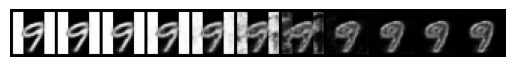

interpolate content:


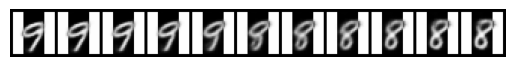

In [123]:
display_util(9, 16, z, vae, 16)

interpolate style:


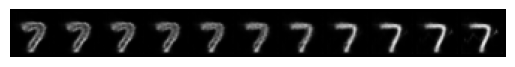

interpolate content:


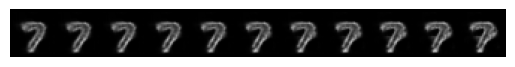

In [124]:
display_util(1, 3, z, vae, int(Z_DIM / 2))

interpolate style:


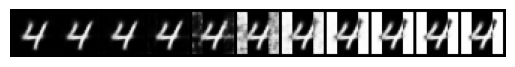

interpolate content:


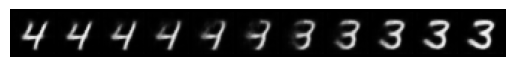

In [125]:
display_util(17, 14, z, vae, int(Z_DIM / 2))

interpolate style:


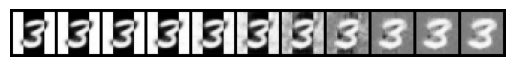

interpolate content:


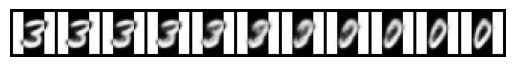

In [99]:
display_util(14, 6, z, vae, int(Z_DIM / 2))

interpolate style:


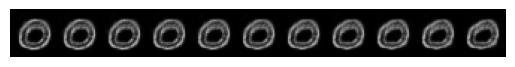

interpolate content:


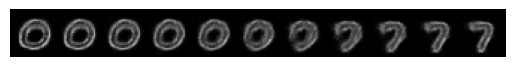

In [126]:
display_util(31, 1, z, vae, int(Z_DIM / 2))

In [127]:
from tqdm import tqdm

mu_cs = []
mu_ss = []
labels = []
styles = []
with torch.no_grad():
    for X, label, style in tqdm(val_dataloader):
        X = X.to(device)
        label = label.to(device)

        _, latent_params = vae(X)
        mu_cs.append(latent_params['mu_c'])
        mu_ss.append(latent_params['mu_s'])
        labels.append(label)
        styles.append(style)

mu_cs = torch.cat(mu_cs, dim=0)
mu_ss = torch.cat(mu_ss, dim=0)
labels = torch.cat(labels, dim=0)
styles = torch.cat(styles, dim=0)

100%|██████████| 79/79 [00:00<00:00, 267.64it/s]


In [128]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_cs_tsne = tsne.fit_transform(mu_cs.cpu().numpy())

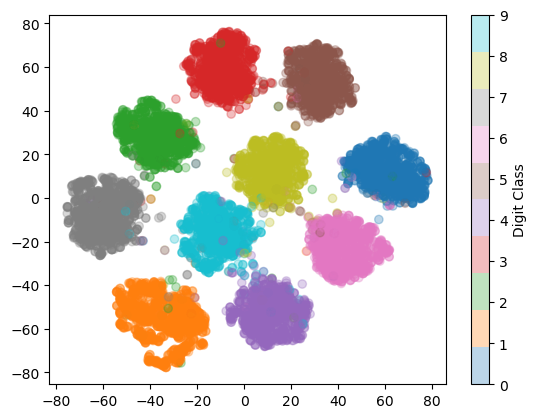

In [129]:
import matplotlib.pyplot as plt

plt.scatter(mu_cs_tsne[:, 0], mu_cs_tsne[:, 1], alpha=0.3, 
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

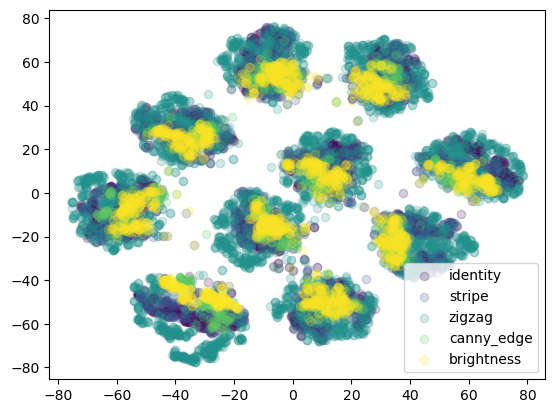

In [130]:
style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', 'brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]

fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_cs_tsne[i,0], mu_cs_tsne[i,1], alpha=0.2, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

In [131]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_ss_tsne = tsne.fit_transform(mu_ss.cpu().numpy())

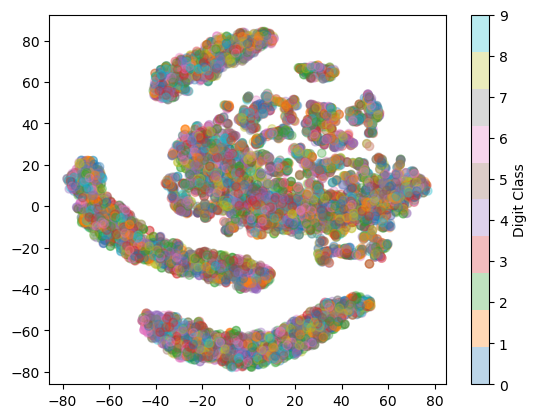

In [132]:
plt.scatter(mu_ss_tsne[:,0], mu_ss_tsne[:,1], alpha=0.3,
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

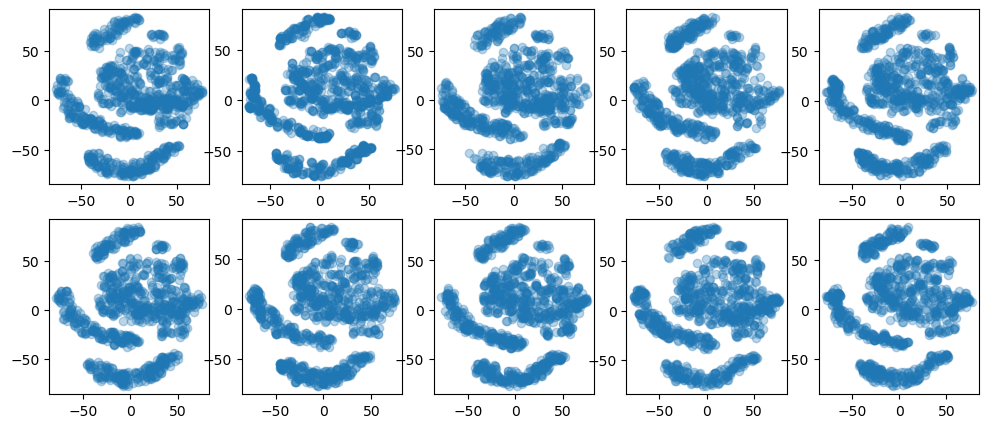

In [133]:
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axs.flat):
    cond = torch.where(labels == i)[0].cpu().numpy()
    ax.scatter(mu_ss_tsne[cond,0], mu_ss_tsne[cond,1], alpha=0.3)

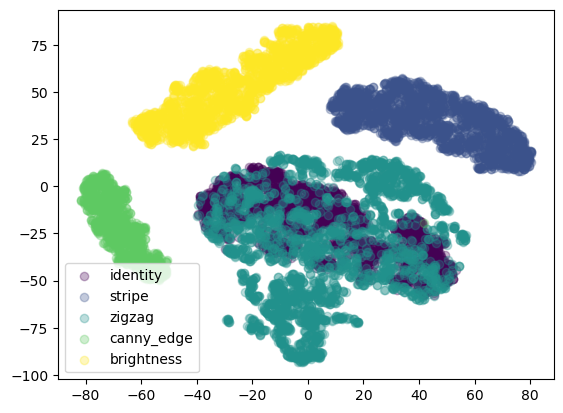

In [107]:
style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', 'brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]

fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_ss_tsne[i,0], mu_ss_tsne[i,1], alpha=0.3, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

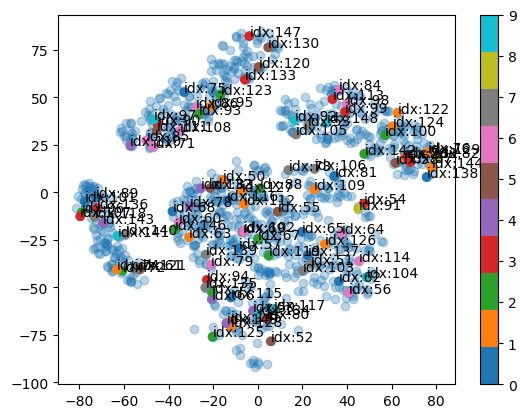

In [110]:
idxs = list(range(50, 150))

plt.scatter(mu_ss_tsne[:1000, 0], mu_ss_tsne[:1000, 1], alpha=0.3)
plt.scatter(mu_ss_tsne[idxs, 0], mu_ss_tsne[idxs, 1], c=labels[idxs].cpu().numpy(), cmap="tab10")
for i in idxs:
    plt.text(mu_ss_tsne[i, 0], mu_ss_tsne[i, 1], f"idx:{i}", fontsize=10)
plt.colorbar()

In [113]:
idx = 1
display(transforms.ToPILImage()(vae.decode(
    torch.cat([mu_cs[idx], mu_ss[idx]]).view(1, -1)
)[0]))

In [114]:
for i in [136, 120, 84, 50, 52]:
    display(transforms.ToPILImage()(vae.decode(
        torch.cat([mu_cs[idx], mu_ss[i]]).view(1, -1)
    )[0]))